In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['figure.figsize'] = [25, 15]

In [3]:
sys.path.insert(0, r'../src')
from function_cache import *

In [4]:
T_contracts_sequence = pd.read_csv('../data/processed/roll_period/T_contracts_sequence.csv', index_col=0)
TF_contracts_sequence = pd.read_csv('../data/processed/roll_period/TF_contracts_sequence.csv', index_col=0)

In [5]:
T_close_0min = pd.read_csv('../data/interim/raw_features/T/0min_before_close.csv', index_col=0, parse_dates=True)
TF_close_0min = pd.read_csv('../data/interim/raw_features/TF/0min_before_close.csv', index_col=0, parse_dates=True)
T_close_5min = pd.read_csv('../data/interim/raw_features/T/5min_before_close.csv', index_col=0, parse_dates=True)
TF_close_5min = pd.read_csv('../data/interim/raw_features/TF/5min_before_close.csv', index_col=0, parse_dates=True)
T_close_10min = pd.read_csv('../data/interim/raw_features/T/10min_before_close.csv', index_col=0, parse_dates=True)
TF_close_10min = pd.read_csv('../data/interim/raw_features/TF/10min_before_close.csv', index_col=0, parse_dates=True)
T_close_15min = pd.read_csv('../data/interim/raw_features/T/15min_before_close.csv', index_col=0, parse_dates=True)
TF_close_15min = pd.read_csv('../data/interim/raw_features/TF/15min_before_close.csv', index_col=0, parse_dates=True)
T_contract_list = list(T_close_0min.columns)
TF_contract_list = list(TF_close_0min.columns)

In [6]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")
TF_roll_period = pd.read_csv(
    "../data/processed/roll_period/TF_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [7]:
T_0min = get_value_df(T_contracts_sequence, T_close_0min, '0min', T_contract_list)
T_0min['spread_price'] = T_0min['active_contract_0min'] - T_0min['deferred_contract_0min']
TF_0min = get_value_df(TF_contracts_sequence, TF_close_0min, '0min', TF_contract_list)
TF_0min['spread_price'] = TF_0min['active_contract_0min'] - TF_0min['deferred_contract_0min']

In [8]:
T_5min = get_value_df(T_contracts_sequence, T_close_5min, '5min', T_contract_list)
T_5min['spread_price'] = T_5min['active_contract_5min'] - T_5min['deferred_contract_5min']
TF_5min = get_value_df(TF_contracts_sequence, TF_close_5min, '5min', TF_contract_list)
TF_5min['spread_price'] = TF_5min['active_contract_5min'] - TF_5min['deferred_contract_5min']

In [9]:
T_10min = get_value_df(T_contracts_sequence, T_close_10min, '10min', T_contract_list)
T_10min['spread_price'] = T_10min['active_contract_10min'] - T_10min['deferred_contract_10min']
TF_10min = get_value_df(TF_contracts_sequence, TF_close_10min, '10min', TF_contract_list)
TF_10min['spread_price'] = TF_10min['active_contract_10min'] - TF_10min['deferred_contract_10min']

In [10]:
T_15min = get_value_df(T_contracts_sequence, T_close_15min, '15min', T_contract_list)
T_15min['spread_price'] = T_15min['active_contract_15min'] - T_15min['deferred_contract_15min']
TF_15min = get_value_df(TF_contracts_sequence, TF_close_15min, '15min', TF_contract_list)
TF_15min['spread_price'] = TF_15min['active_contract_15min'] - TF_15min['deferred_contract_15min']

In [11]:
T_0min.to_csv('../data/processed/price_before_close/T_0min.csv')
TF_0min.to_csv('../data/processed/price_before_close/TF_0min.csv')
T_5min.to_csv('../data/processed/price_before_close/T_5min.csv')
TF_5min.to_csv('../data/processed/price_before_close/TF_5min.csv')
T_10min.to_csv('../data/processed/price_before_close/T_10min.csv')
TF_10min.to_csv('../data/processed/price_before_close/TF_10min.csv')
T_15min.to_csv('../data/processed/price_before_close/T_15min.csv')
TF_15min.to_csv('../data/processed/price_before_close/TF_15min.csv')

In [12]:
T_features = pd.read_csv('../data/processed/candidate_features/T_features.csv', index_col=0)
TF_features = pd.read_csv('../data/processed/candidate_features/TF_features.csv', index_col=0)

In [13]:
def spread_change_during_roll_asym(spread_price_start, spread_price_end, name, roll_period, contract_list):

    # roll period from the aspect of active contract
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active["spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:
        # the deferred contract is the next contract after active contract
        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, "start"]
        end_date = roll_period_for_active.loc[active_contract, "end"]

        # spread change is the change of difference between acitve price and deferred price during the roll period
        spread_change = (spread_price_end.loc[end_date, "spread_price"] - spread_price_start.loc[start_date, "spread_price"])
        roll_period_for_active.loc[active_contract, "spread_change"] = spread_change
        
        result = pd.DataFrame(roll_period_for_active["spread_change"])
        result.columns = [name]
    return result

## T Spread Change Before Roll Period

### Multiple ys

,0min_0min,0min_5min,0min_10min,0min_15min,5min_0min,5min_5min,5min_10min,5min_15min,10min_0min,10min_5min,10min_10min,10min_15min,15min_0min,15min_5min,15min_10min,15min_15min,contract_code
contract,,,,,,,,,,,,,,,,,
T1509,0.555,0.550,0.575,0.565,0.620,0.615,0.640,0.630,0.58,0.575,0.600,0.59,0.575,0.570,0.595,0.585,0
T1512,0.500,0.500,0.535,0.540,0.455,0.455,0.490,0.495,0.38,0.380,0.415,0.42,0.455,0.455,0.490,0.495,1
T1603,0.300,0.295,0.255,0.260,0.290,0.285,0.245,0.250,0.30,0.295,0.255,0.26,0.265,0.260,0.220,0.225,2


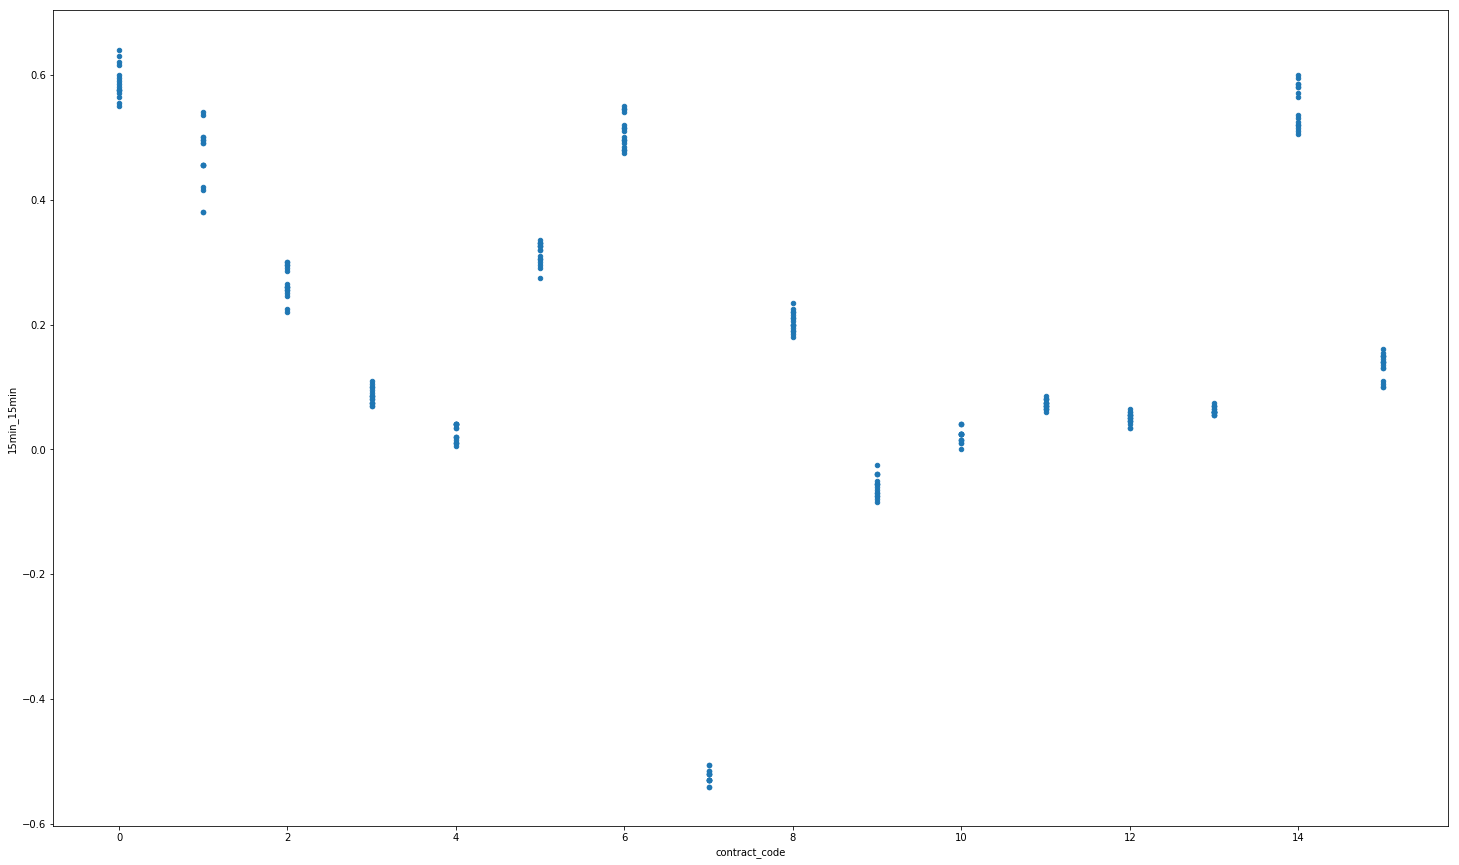

In [14]:

T_price_list = [T_0min, T_5min, T_10min, T_15min]
T_spread_change = pd.DataFrame()

for i, T_price_start in enumerate(T_price_list):
    for j, T_price_end in enumerate(T_price_list):
        
        name = str(5 * i) + 'min_' + str(5 * j) + 'min'
        spread_change = spread_change_during_roll_asym(T_price_start, T_price_end, name, T_roll_period, T_contract_list)
        T_spread_change = pd.concat([T_spread_change, spread_change], axis=1)

T_spread_change['contract_code'] = range(T_spread_change.shape[0])

ax1 = T_spread_change.plot.scatter(x='contract_code', y='0min_0min')
for name in T_spread_change.columns[1:-1]:
    ax2 = T_spread_change.plot.scatter(x='contract_code', y=name, ax=ax1)

T_spread_change.head(3)

In [16]:
T_spread_change.to_csv('../data/processed/different_ys/T_spread_change.csv')
TF_spread_change.to_csv('../data/processed/different_ys/TF_spread_change.csv')

### Lasso Regression

In [68]:
#alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
alphas = [0.03]

def lasso_choose_features(x, y, alphas):
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, normalize=True)
        lasso.fit(x, y)
        print(alpha, '-------', lasso.score(x, y))
        print(lasso.sparse_coef_)
        print()

for name in T_spread_change.columns[:-1]:
    print(name)
    lasso_choose_features(T_features.values, T_spread_change[name].values, alphas)
    print()


0min_0min
0.03 ------- 0.03482370536282442
  (0, 18)	0.018328811074329914


0min_5min
0.03 ------- 0.027736833247160367
  (0, 18)	0.014815614395400358


0min_10min
0.03 ------- 0.03568255251683128
  (0, 9)	-0.012956250197906305
  (0, 18)	0.01695010319764654


0min_15min
0.03 ------- 0.014294961606760692
  (0, 18)	0.007725125363828455


5min_0min
0.03 ------- 0.01154020724517102
  (0, 18)	0.006052506742423259


5min_5min
0.03 ------- 0.004776365137012961
  (0, 18)	0.0025393100634937276


5min_10min
0.03 ------- 0.0319159335760828
  (0, 9)	-0.04596201579426166
  (0, 18)	0.005106054504097997


5min_15min
0.03 ------- 0.008471346212217457
  (0, 9)	-0.01589268458961548


10min_0min
0.03 ------- 0.01132188885561769
  (0, 18)	0.0054534111607453814


10min_5min
0.03 ------- 0.003967571004006687
  (0, 18)	0.0019402144818158505


10min_10min
0.03 ------- 0.00742035188720358
  (0, 18)	0.00390502346907115


10min_15min
0.03 ------- 0.0



15min_0min
0.03 ------- 0.0116451691258187
  (0, 18)	0.0059

### LassoCV

In [65]:
x = T_features.values
y = T_spread_change['0min_0min'].values
for i in range(2, 16):
    print('cv:', i)
    lassoCV = LassoCV(normalize=True, cv=i, max_iter=10000)#, fit_intercept=False)
    lassoCV.fit(x, y)
    print(lassoCV.score(x, y))
    print(lassoCV.alpha_)
    print()

cv: 2
-2.220446049250313e-16
0.03263326054230106

cv: 3
0.9928763026544273
0.00043139249919480605

cv: 4
0.02928721812236257
0.03043388800146209

cv: 5
-2.220446049250313e-16
0.03263326054230106

cv: 6
0.9728523528680777
0.0017415389644785337

cv: 7
0.8543507681309622
0.0061148772168906065

cv: 8
0.8543507681309622
0.0061148772168906065

cv: 9
0.9046929383053621
0.004625680367077053

cv: 10
0.9046929383053621
0.004625680367077053

cv: 11
0.8945224651501424
0.004959965437113403

cv: 12
0.9046929383053621
0.004625680367077053

cv: 13
-2.220446049250313e-16
0.03263326054230106

cv: 14
-2.220446049250313e-16
0.03263326054230106

cv: 15
-2.220446049250313e-16
0.03263326054230106



### T-score of the Chosen Feature

In [22]:
T_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=T_spread_change.columns[:-1])

for name in T_spread_change.columns[:-1]:
    
    print('name: ', name)
    x = T_features['-1d_corr_def_OI_spread'].values.reshape(-1, 1)
    y = T_spread_change[name].values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    T_tscore.loc['t_value', name] = est2.tvalues[1]
    T_tscore.loc['p_value', name] = est2.pvalues[1]
    print()

name:  0min_0min
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.061
Date:                Tue, 06 Aug 2019   Prob (F-statistic):             0.0635
Time:                        16:52:18   Log-Likelihood:              -0.025840
No. Observations:                  16   AIC:                             4.052
Df Residuals:                      14   BIC:                             5.597
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1180      0.071   

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stat

In [23]:
print(T_tscore.T)
T_tscore_t = T_tscore.T.astype(float)

idx_list = [str(i*5)+'min' for i in range(4)]
T_pvalues = pd.DataFrame(T_tscore_t['p_value'].values.reshape(4, 4), index=idx_list, columns=idx_list)

T_pvalues.style.apply(background_gradient,
               cmap='PuBu',
               m=T_pvalues.min().min(),
               M=T_pvalues.max().max(),
               low=0,
               high=0.2)

             t_value    p_value
0min_0min    2.01521  0.0635005
0min_5min    1.96689   0.069339
0min_10min    1.8952  0.0789039
0min_15min   1.89411  0.0790584
5min_0min    1.91614  0.0759935
5min_5min    1.87069  0.0824378
5min_10min   1.80201  0.0931098
5min_15min   1.79732  0.0938825
10min_0min   2.01774  0.0632078
10min_5min   1.96677   0.069354
10min_10min  1.89406  0.0790656
10min_15min  1.89951  0.0782969
15min_0min    1.9399  0.0728088
15min_5min   1.89093  0.0795095
15min_10min  1.81963  0.0902604
15min_15min  1.82048  0.0901249


,0min,5min,10min,15min
0min,0.0635005,0.069339,0.0789039,0.0790584
5min,0.0759935,0.0824378,0.0931098,0.0938825
10min,0.0632078,0.069354,0.0790656,0.0782969
15min,0.0728088,0.0795095,0.0902604,0.0901249


### Regression for all Features

In [24]:
T_features_rep = T_features.copy()
T_features_rep = T_features_rep.append([T_features_rep]*15).sort_index()
T_features_rep.shape

plt.rcParams['figure.figsize'] = [5, 4]

x = T_features_rep.values
y = T_spread_change.iloc[:, :-1].values.reshape(-1, 1)

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2688.
Date:                Tue, 06 Aug 2019   Prob (F-statistic):          9.37e-258
Time:                        16:52:26   Log-Likelihood:                 626.96
No. Observations:                 256   AIC:                            -1222.
Df Residuals:                     240   BIC:                            -1165.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0884      0.002    -42.368      0.0

### Chosen Feature and y

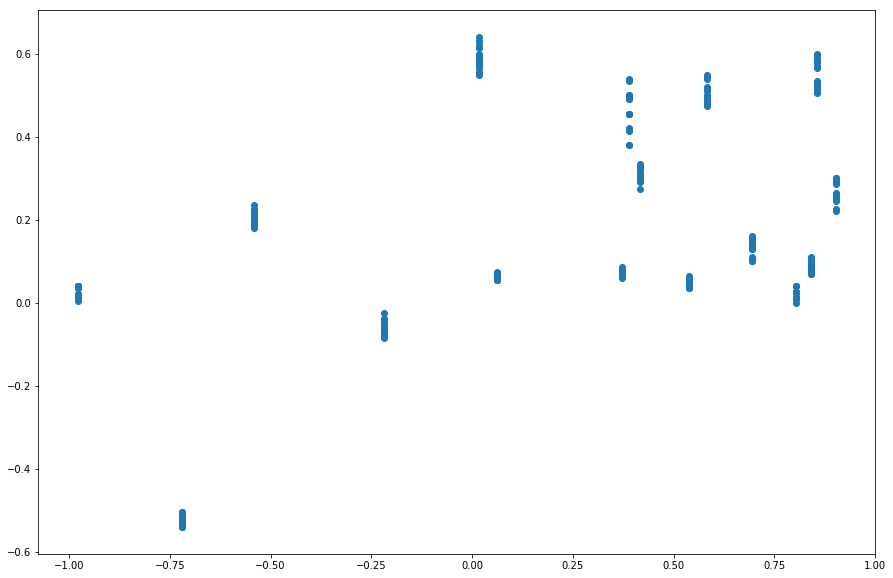

In [25]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.scatter(x=x[:,18], y=y)

## TF Spread Change Before Roll Period

### Multiple ys

,0min_0min,0min_5min,0min_10min,0min_15min,5min_0min,5min_5min,5min_10min,5min_15min,10min_0min,10min_5min,10min_10min,10min_15min,15min_0min,15min_5min,15min_10min,15min_15min,contract_code
contract,,,,,,,,,,,,,,,,,
TF1312,-0.032,-0.048,-0.034,-0.036,-0.052,-0.068,-0.054,-0.056,-0.050,-0.066,-0.052,-0.054,-0.016,-0.032,-0.018,-0.020,0
TF1403,-0.218,-0.204,-0.202,-0.202,-0.236,-0.222,-0.220,-0.220,-0.238,-0.224,-0.222,-0.222,-0.218,-0.204,-0.202,-0.202,1
TF1406,-0.156,-0.170,-0.206,-0.198,-0.144,-0.158,-0.194,-0.186,-0.150,-0.164,-0.200,-0.192,-0.146,-0.160,-0.196,-0.188,2


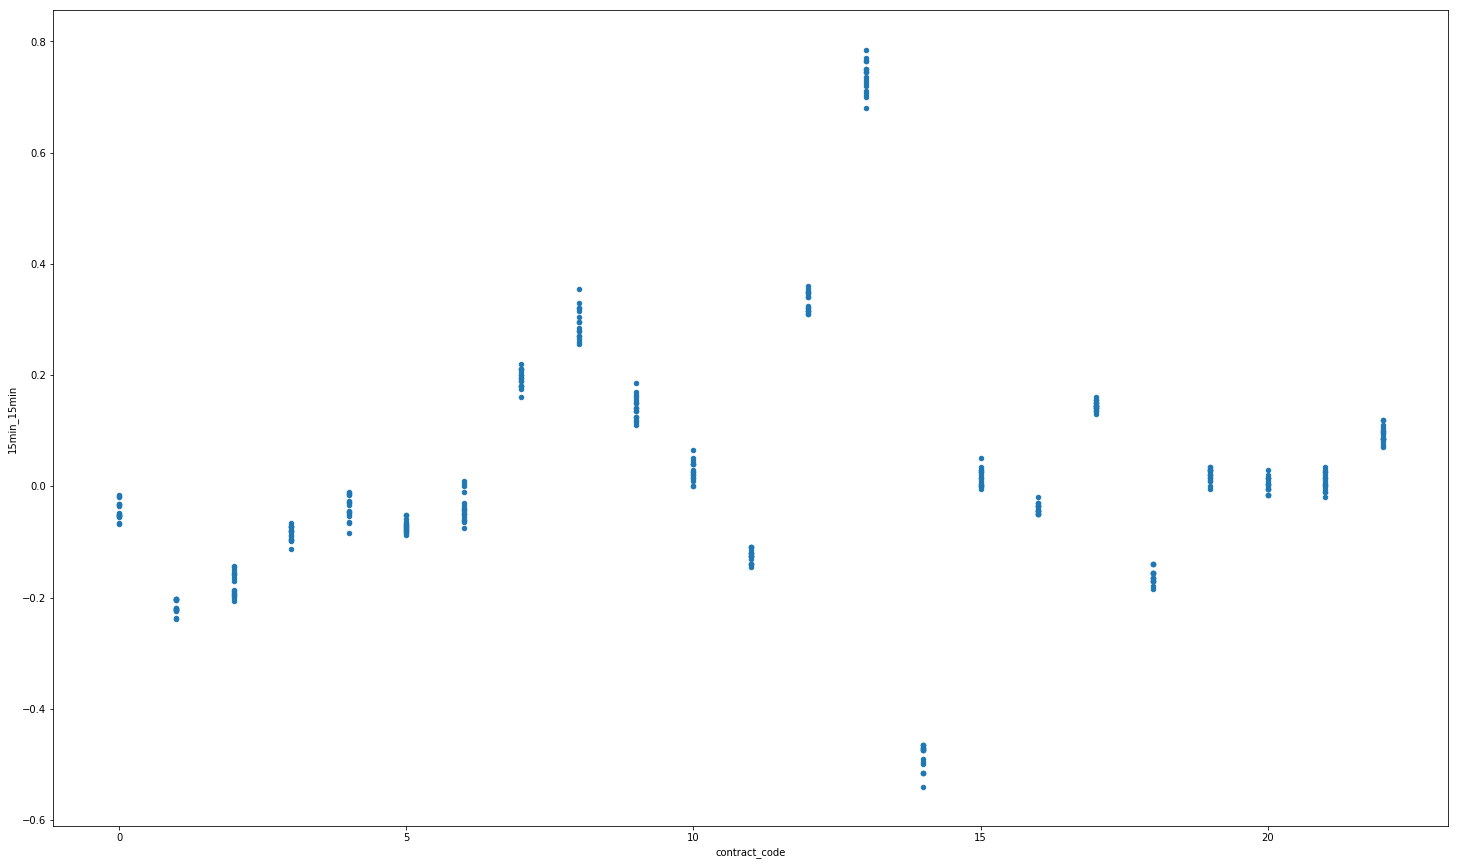

In [15]:
TF_price_list = [TF_0min, TF_5min, TF_10min, TF_15min]
TF_spread_change = pd.DataFrame()

for i, TF_price_start in enumerate(TF_price_list):
    for j, TF_price_end in enumerate(TF_price_list):
        
        name = str(5 * i) + 'min_' + str(5 * j) + 'min'
        spread_change = spread_change_during_roll_asym(TF_price_start, TF_price_end, name, TF_roll_period, TF_contract_list)
        TF_spread_change = pd.concat([TF_spread_change, spread_change], axis=1)

TF_spread_change['contract_code'] = range(TF_spread_change.shape[0])

ax1 = TF_spread_change.plot.scatter(x='contract_code', y='0min_0min')
for name in TF_spread_change.columns[1:-1]:
    ax2 = TF_spread_change.plot.scatter(x='contract_code', y=name, ax=ax1)

TF_spread_change.head(3)

### Lasso Regression

In [27]:
#alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
alphas = [0.018]

for name in TF_spread_change.columns[:-1]:
    print(name)
    lasso_choose_features(TF_features.values, TF_spread_change[name].values, alphas)
    print()

0min_0min
0.018 ------- 0.10594590326228825
  (0, 1)	0.10356611625735075
  (0, 19)	0.025108035607200034


0min_5min
0.018 ------- 0.0897545394113416
  (0, 1)	0.14002032974274561


0min_10min
0.018 ------- 0.08139320947238815
  (0, 1)	0.12845582387997212


0min_15min
0.018 ------- 0.07290381323387207
  (0, 1)	0.11309469786137934


5min_0min
0.018 ------- 0.15388424081348984
  (0, 1)	0.16410218755657646
  (0, 19)	0.03160257871994063


5min_5min
0.018 ------- 0.13921191487568907
  (0, 1)	0.20366027180165233
  (0, 19)	0.0046775830260553635


5min_10min
0.018 ------- 0.12809214905851296
  (0, 1)	0.1992486177317744
  (0, 19)	0.0004866624931130271


5min_15min
0.018 ------- 0.12013026571524842
  (0, 1)	0.184715515650371


10min_0min
0.018 ------- 0.14412257828084718
  (0, 1)	0.16319474277708304
  (0, 19)	0.026906903319196387


10min_5min
0.018 ------- 0.1294926810641409
  (0, 1)	0.20271925656343412


10min_10min
0.018 ------- 0.12094743007538755
  (0, 1)	0.19115475070066082


10min_15min
0.01

In [52]:
x = TF_features.values
y = TF_spread_change['0min_0min'].values

lassoCV = LassoCV(normalize=True, cv=3)
lassoCV.fit(x, y)
print(lassoCV.score(x, y))
print(lassoCV.alpha_)
print()

2.220446049250313e-16
0.022935113928096912



### t-value of the Chosen Feature

In [28]:
TF_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=TF_spread_change.columns[:-1])

for name in TF_spread_change.columns[:-1]:
    
    print('name: ', name)
    x = TF_features['-1d_corr_def_OI_spread'].values.reshape(-1, 1)
    y = TF_spread_change[name].values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    TF_tscore.loc['t_value', name] = est2.tvalues[1]
    TF_tscore.loc['p_value', name] = est2.pvalues[1]
    print()

name:  0min_0min
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.135
Date:                Tue, 06 Aug 2019   Prob (F-statistic):             0.0341
Time:                        16:52:45   Log-Likelihood:                 3.7306
No. Observations:                  23   AIC:                            -3.461
Df Residuals:                      21   BIC:                            -1.190
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0346      0.045   

In [29]:
TF_tscore.T

,t_value,p_value
0min_0min,2.26609,0.0341356
0min_5min,2.14163,0.0441061
0min_10min,2.04762,0.0533096
0min_15min,2.01712,0.0566461
5min_0min,2.45187,0.0230469
5min_5min,2.32918,0.0299125
5min_10min,2.23841,0.0361562
5min_15min,2.21146,0.0382272
10min_0min,2.40841,0.0252916
10min_5min,2.28495,0.0328192


In [30]:
TF_tscore_t = TF_tscore.T.astype(float)

idx_list = [str(i*5)+'min' for i in range(4)]
TF_pvalues = pd.DataFrame(TF_tscore_t['p_value'].values.reshape(4, 4), index=idx_list, columns=idx_list)

TF_pvalues.style.apply(background_gradient,
               cmap='PuBu',
               m=TF_pvalues.min().min(),
               M=TF_pvalues.max().max(),
               low=0,
               high=0.2)

,0min,5min,10min,15min
0min,0.0341356,0.0441061,0.0533096,0.0566461
5min,0.0230469,0.0299125,0.0361562,0.0382272
10min,0.0252916,0.0328192,0.0397888,0.0422305
15min,0.0237369,0.0301442,0.0365782,0.0388782


### Regression for all Features

In [31]:
TF_features_rep = TF_features.copy()
TF_features_rep = TF_features_rep.append([TF_features_rep]*15).sort_index()
TF_features_rep.shape

plt.rcParams['figure.figsize'] = [5, 4]

x = TF_features_rep.values
y = TF_spread_change.iloc[:, :-1].values.reshape(-1, 1)

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2733.
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:54:30   Log-Likelihood:                 972.14
No. Observations:                 368   AIC:                            -1898.
Df Residuals:                     345   BIC:                            -1808.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.003     47.360      0.0

### Chosen Feature and y

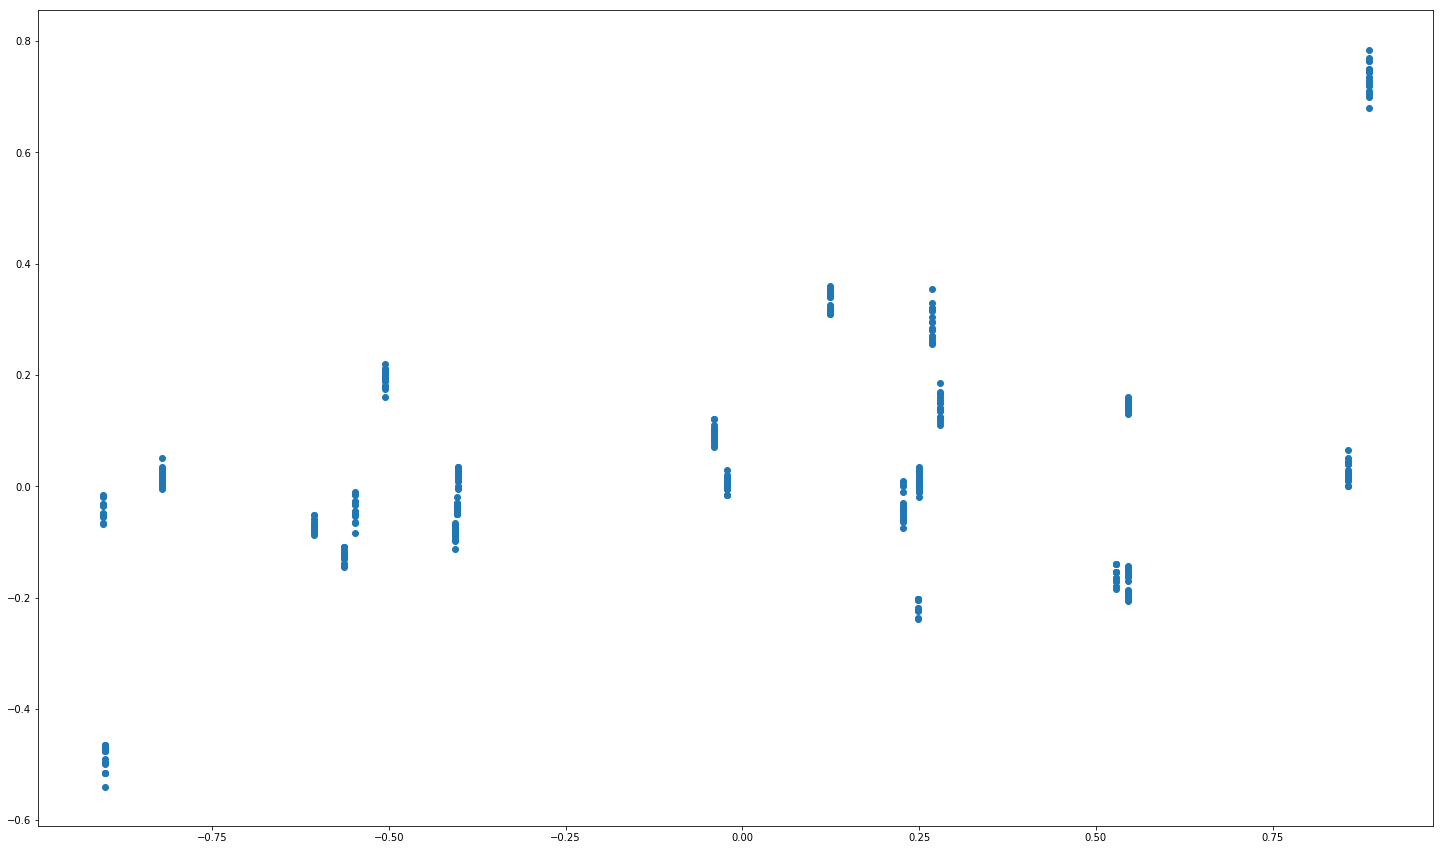

In [32]:
plt.rcParams['figure.figsize'] = [25, 15]

plt.scatter(x=x[:,18], y=y)